# **Notes** 
### Purpose: Calculates the total trend in TXx and TXm for the HadGEM3 model data

# **Preparation**

In [1]:
import numpy as np # for storing vector and matrix data
import matplotlib.pyplot as plt # to plot figures
import netCDF4 as nc #to read netCDF files
import cartopy.crs as ccrs # to plot maps
# (ergens in test ook: import cartopy as cart)
import cartopy.feature as cf
# from matplotlib import ticker
import scipy.io
from scipy.stats import pearsonr # voor persistence
import scipy.stats as stats
# from cartopy.util import add_cyclic_point
import os
import xarray as xr
import pickle

# **Functions**

In [2]:
def load_data(path,*variables_to_add):
  """
Provide the path to a file and the variables you want to extract
  """
  data = nc.Dataset(path, mode='r')
  variable_list = []
  for variable in variables_to_add:
    var =data.variables[variable][:]
    variable_list.append(var)
  return variable_list

In [3]:
def plot_variable(lat, lon, variable,folder,name):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "degrees celcius/GWD", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [4]:
def extract_area(S, N, W, E, lat, lon, variable,event = False):
    """
    This function slices the data given the S, N, W, E bounds. Use event = True if there are only two dimensions (since then there is no time dimension), this means after using this
    function you need to use event[0] to get the data
    """
    # Change longitude data to go from -180 to 180
    for i in range(len(lon)):
        if lon[i] > 180:
          lon[i] = lon[i] - 360
        else:
          lon[i] = lon[i]

    # Calculate the index of the bounds
    sIndex = np.argmin(np.abs(lat - S))
    nIndex = np.argmin(np.abs(lat - N))
    wIndex = np.argmin(np.abs(lon - W))
    eIndex = np.argmin(np.abs(lon - E))

    if event:
        variable = np.expand_dims(variable, axis = 0)

    if wIndex > eIndex: # If the west index is higher than the east index, think of the right side of the world map as left boundary and vice versa
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = np.concatenate((lon[wIndex:], lon[:eIndex + 1]))
        variableSlice = np.concatenate((variable[:, sIndex: nIndex + 1, wIndex:], variable[:, sIndex: nIndex + 1, :eIndex + 1]), axis = 2)

    else:
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = lon[wIndex: eIndex + 1]
        variableSlice = variable[:, sIndex: nIndex + 1, wIndex: eIndex + 1]

    return latSlice, lonSlice, variableSlice

In [5]:
def extract_season_year(variable,yearlength,start_day,end_day, start_year = False, end_year = False):
  """
  Start day and end day should be the actuall day, so if you want the second day, third and fourth day, do 2,4 (151,240 would be JJA?) jaren ook: 1,5 is 1 tot en met 5
  nadenken dat als gaat checken met al gesneden data dat yearlenght 90 is als op 3 maanden gesneden
  """
  start_index = start_day-1
  end_index = end_day-1
  if start_year == False and end_year == False:
    years = variable.shape[0]//yearlength
    for year in range(years):
      if year == 0:
        selected_data = variable[(year*yearlength)+start_index:(end_index+1),:,:] # +1 omdat tot is ipv tot en met voor de laatste
      elif year != 0:
        add_data = variable[(year*yearlength)+start_index:(year*yearlength)+(end_index+1),:,:] # stel is 10, na 1 jaar dan 370 is TOT 370 dus index 369 en dan is dag 10
        selected_data = np.concatenate((selected_data, add_data), axis = 0)
    return selected_data
  else:
    years = (end_year-start_year) + 1
    for year in range(years):
      year_multiplier = (year + start_year) - 1
      if year == 0:
        selected_data = variable[(year_multiplier*yearlength)+start_index:(year_multiplier*yearlength)+(end_index+1),:,:] # +1 omdat tot is ipv tot en met voor de laatste
      elif year != 0:
        add_data = variable[(year_multiplier*yearlength)+start_index:(year_multiplier*yearlength)+(end_index+1),:,:] # stel is 10, na 1 jaar dan 370 is TOT 370 dus index 369 en dan is dag 10
        selected_data = np.concatenate((selected_data, add_data), axis = 0)
    return selected_data

In [6]:
def global_warming_degree_function(temp_data,adjusted_yearlength, start_year, end_year):
    """
    Hardcodes that its a 5 year centred running average, moet temp_data van seizoen of hele jaar?
    Start en end year alleen voor hoeveel jaar, niet ook echt die eruit filteren! Dan moet extract_season_year gebruiken!
    """
    amount_of_years = (end_year - start_year) + 1
    list_for_finalized_averages = []
    list_for_GWD = []
    reshaped_data = temp_data.reshape(amount_of_years,adjusted_yearlength,temp_data.shape[1],temp_data.shape[2])
    for i in range(amount_of_years):
        if i == 0:
            filtered_data = reshaped_data[0:3,:,:,:]
        elif i == 1:
            filtered_data = reshaped_data[0:4,:,:,:]
        elif i == (amount_of_years-1): #laatste
            filtered_data = reshaped_data[(i-2):,:,:,:]
        elif i == (amount_of_years-2): 
            filtered_data = reshaped_data[(i-2):,:,:,:]
        else:
            filtered_data = reshaped_data[(i-2):(i+3),:,:,:]
        mean_to_add = np.mean(filtered_data) # zou alle axis moeten meanen
        list_for_finalized_averages.append(mean_to_add)

    for average in list_for_finalized_averages:
        GWD_value = average - list_for_finalized_averages[-1]
        list_for_GWD.append(GWD_value)
    
    return list_for_GWD

In [7]:
def temperature_trends__TXx_TXm(max_temp_data,adjusted_yearlength, start_year, end_year):
    """
    Needs to use the maximum daily temperature data (TASMAX),note that instead of looping through the years, you could also just do np.mean(...,axis = 1)
    because the o.g. reshaped data is still (years,months,lat,lon) (or lon/lat), so than you would get (years,lat,lon) 
    Nog doen dat trend averaged over blauwe box
    """
    amount_of_years = (end_year - start_year) + 1
    reshaped_data = max_temp_data.reshape(amount_of_years,adjusted_yearlength,max_temp_data.shape[1],max_temp_data.shape[2])
    list_for_Txx_values = []
    list_for_Txm_values = []

    for i in range(amount_of_years):
        filtered_data = reshaped_data[i,:,:,:]
        max_per_season = np.max(filtered_data,axis = 0)
        list_for_Txx_values.append(max_per_season)
        mean_per_season = np.mean(filtered_data, axis = 0)
        list_for_Txm_values.append(mean_per_season)

    array_for_TXx = np.array(list_for_Txx_values)
    array_for_TXm = np.array(list_for_Txm_values)
    
    return array_for_TXx, array_for_TXm

In [8]:
def regression_temperature_trend(GWD_list,temperature_trend_array):

    # Create empty arrays for the regression outputs
    shape_1 = temperature_trend_array.shape[1]
    shape_2 = temperature_trend_array.shape[2]

    slope_array = np.zeros((shape_1,shape_2))
    intercept_array = np.zeros((shape_1,shape_2))
    rvalue_array = np.zeros((shape_1,shape_2))
    pvalue_array = np.zeros((shape_1,shape_2))
    stderr_array = np.zeros((shape_1,shape_2))

    for i in range(shape_1):
        for j in range(shape_2):
            values_at_specific_coordinates = temperature_trend_array[:, i, j] # Find the values for all years in 1 grid cell
            slope, intercept, rvalue, pvalue, stderr = stats.linregress(GWD_list, values_at_specific_coordinates)
            
            # Store the regression outputs in the empty arrays
            slope_array[i, j] = slope
            intercept_array[i, j] = intercept
            rvalue_array[i, j] = rvalue
            pvalue_array[i, j] = pvalue
            stderr_array[i, j] = stderr

    return slope_array,intercept_array,rvalue_array,pvalue_array,stderr_array

In [9]:
def significance_standard_deviation(mean_array,standard_deviation_array):
    mask = np.zeros((mean_array.shape[0],mean_array.shape[1]))
    for i in range(mean_array.shape[0]):
        for j in range(mean_array.shape[1]):
            mean_value = mean_array[i,j]
            absolute_mean = np.abs(mean_value)
            std_value = standard_deviation_array[i,j]
            threshold = std_value*2
            if absolute_mean > threshold:
                mask[i,j] = 0
            else:
                mask[i,j] = 1
    return mask

In [10]:
def plot_differencet(lat, lon, variable,significance_mask,folder,name):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[-2,0,2], hatches=[None, '////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [11]:
def mean_weighted(data):
    """
    Parameters
    ----------
    data : data
         data.
    """
    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(data['lat'])) * xr.ones_like(data['lon']) # effective area weights
    mean_ = ((data * cos_lat_2d).sum(dim=['lat','lon']) /
                 cos_lat_2d.sum(dim=['lat','lon']))
    return mean_

In [12]:
def global_warming_degree_function_area_weighted(temp_data_path,adjusted_yearlength, start_year, end_year, variable = "t2m"):
    """
    Hardcodes that its a 5 year centred running average, moet temp_data van seizoen of hele jaar?
    Start en end year alleen voor hoeveel jaar, niet ook echt die eruit filteren! Dan moet extract_season_year gebruiken!
    doet weighted mean van de gegeven variable, hardcodes dat lat en lon heet (dus als variables in data lattitude en longitude hebt = aanpasses)
    door for i in range(amount_of_years) hardcodes ook dat in 1950 begint!
    end year kan hardcode 2014 voor reshape want is model data dus tot 2014 is alles
    """

    #Open the NetCDF file with xarray
    dataset = xr.open_dataset(temp_data_path)

    #Calculate the area weighted mean
    weighted_mean = mean_weighted(dataset[variable])

    #Transform the xarray DataArray into an array
    daily_mean_list = weighted_mean.values.tolist()
    daily_mean_array = np.array(daily_mean_list)
    
    amount_of_years = (end_year - start_year) + 1
    list_for_finalized_averages = []
    list_for_GWD = []
    reshaped_data = daily_mean_array.reshape(amount_of_years,adjusted_yearlength)
    for i in range(amount_of_years):
        if i == 0:
            filtered_data = reshaped_data[0:3,:]
        elif i == 1:
            filtered_data = reshaped_data[0:4,:]
        elif i == (amount_of_years-1): #laatste
            filtered_data = reshaped_data[(i-2):,:]
        elif i == (amount_of_years-2): 
            filtered_data = reshaped_data[(i-2):,:]
        else:
            filtered_data = reshaped_data[(i-2):(i+3),:]
        mean_to_add = np.mean(filtered_data) # zou alle axis moeten meanen
        list_for_finalized_averages.append(mean_to_add)

    for average in list_for_finalized_averages:
        GWD_value = average - list_for_finalized_averages[-1]
        list_for_GWD.append(GWD_value)
    
    return list_for_GWD

In [13]:
def mean_weighted_masked(data,mask):
    """
    Parameters
    ----------
    data : data
         data.
    """
    ## Calculate global-mean surface temperature (GMST)
    mask_af = np.squeeze(mask)
    cos_lat_2d = np.cos(np.deg2rad(data['lat'])) * xr.ones_like(data['lon']) # effective area weights
    if cos_lat_2d.shape != mask_af.shape:
        print (f"WARNING: shapes of mask ({mask_af}) and cos_lat2d  ({cos_lat_2d.shape}) do no match (in mean_weigted2 (zelf))")
    cos_lat_2d_masked = cos_lat_2d*mask_af
    mean_ = ((data * cos_lat_2d).sum(dim=['lat','lon']) /
                 cos_lat_2d_masked.sum(dim=['lat','lon']))
    return mean_

In [14]:
def area_averaged_trend(data,lat,lon,landmask_path,S,N,W,E):
    """
    Calculates the area weighted mean land area trend of a region using a land mask
    """

    #Load the mask and extract the selected region for the mask and actual data
    latm,lonm,mask_data = load_data(landmask_path,"lat","lon","tx")
    latm_box,lonm_box,mask_box = extract_area(S,N,W,E,latm,lonm,mask_data,event = False)
    latd_box,lond_box,data_box = extract_area(S,N,W,E,lat,lon,data,event = True)

    #Prepare mask
    min_data = np.min(mask_box)
    if min_data == -9999.0:
        mask_box = np.where(mask_box == -9999.0, np.nan, mask_box)
    mask = mask_box/mask_box
    if mask.shape != data_box.shape:
        print ("WARNING: shape of mask and data do not match (zelf)")
    
    #Perform analyses and plot to check
    masked_data = data_box*mask
    #plot_variable(latd_box,lond_box,masked_data[0],"test","test")

    #Turn into xarray and take area weighted average
    time_indices = np.arange(masked_data.shape[0])  # Because you used event = True in extract area both now have three dimensions
    data_xr_array = xr.DataArray(masked_data, dims=['time', 'lat', 'lon'], coords={'time': time_indices, 'lat': latd_box, 'lon': lond_box})
    mean_trend = mean_weighted_masked(data_xr_array,mask)
    mean_list = mean_trend.values.tolist()
    #print (f"weighted mean = {mean_list}, normal mean = {np.mean(masked_data)}")

    return mean_list

# **Combined**

In [15]:
def temperature_trend_combined(data_path_tas,data_path_tasmax,amount_of_ensembles_to_run,S,N,W,E,start_day,end_day,save_path,season_name,land_mask_path,Sa,Na,Wa,Ea,save_output = False, plot_output = False):
  """
  For now assumes we analyze 1950-2014 so you do not need the 1850-1949 file
  Start en end year in GWD en TXx/TXm functie alleen voor hoeveel jaar, niet ook echt die eruit filteren! Dan moet extract_season_year gebruiken!
  """
  #Create empty lists
  list_for_mean_model_slope_TXx = []
  list_for_mean_model_slope_TXm = []

  list_for_TXx_area_average = []
  list_for_TXm_area_average = []

  #Prepare ensemble members
  index_1850 = 0
  index_1950 = 1
  max_index = (amount_of_ensembles_to_run*2)-1

  folder_path_tas = sorted(os.listdir(data_path_tas)) # mean T model
  folder_path_tasmax = sorted(os.listdir(data_path_tasmax)) # max T model
  # Loop through ensemble members and determine paths
  while index_1950 <= max_index:
    file1950_tas = folder_path_tas[index_1950]
    data_path1950_tas = os.path.join(data_path_tas, file1950_tas)

    file1950_tasmax = folder_path_tasmax[index_1950]
    data_path1950_tasmax = os.path.join(data_path_tasmax, file1950_tasmax)
    #Load data (als 1950-2014 doet is geen past nodig)
    #lat_model_global_tas,lon_model_global_tas,tas_model_global = load_data(data_path1950_tas,"lat","lon","tas")
    lat_model_global_tasmax,lon_model_global_tasmax,tasmax_model_global = load_data(data_path1950_tasmax,"lat","lon","tasmax")

    #Calculate GWD (do this before slicing the data)
    GWD = global_warming_degree_function_area_weighted(data_path1950_tas,360, 1950, 2014,variable = "tas") #1950-2014 niet om te selecten, alleen hoeveelheid jaar
    
    #Extract area and season for max T en calculte trends
    lat_model_extracted,lon_model_extracted,tasmax_model_extracted = extract_area(S, N, W, E,lat_model_global_tasmax,lon_model_global_tasmax,tasmax_model_global,event = False)
    tasmax_model_filtered = extract_season_year(tasmax_model_extracted,360,start_day,end_day)
    Txx_array,Txm_array = temperature_trends__TXx_TXm(tasmax_model_filtered,90, 1950, 2014) #90 hardcoded, als longer warm period is moet anders! Ook 1950-2014 niet om te selecten, alleen hoeveelheid jaar
    
    #Perform regressions
    slope_Txx_model,intercept_Txx_model,rvalue_Txx_model,pvalue_Txx_model,stderr_Txx_model = regression_temperature_trend(GWD,Txx_array)
    slope_Txm_model,intercept_Txm_model,rvalue_Txm_model,pvalue_Txm_model,stderr_Txm_model = regression_temperature_trend(GWD,Txm_array)
    
    list_for_mean_model_slope_TXx.append(slope_Txx_model)
    list_for_mean_model_slope_TXm.append(slope_Txm_model)
    
    mean_Txx = area_averaged_trend(slope_Txx_model,lat_model_extracted,lon_model_extracted,land_mask_path,Sa,Na,Wa,Ea)
    mean_Txm = area_averaged_trend(slope_Txm_model,lat_model_extracted,lon_model_extracted,land_mask_path,Sa,Na,Wa,Ea)

    mean_Txx_value = mean_Txx[0]
    list_for_TXx_area_average.append(mean_Txx_value)
    mean_Txm_value = mean_Txm[0]
    list_for_TXm_area_average.append(mean_Txm_value)

    #Make plots
    #plot_variable(lat_model_extracted,lon_model_extracted,slope_Txx_model,"test1name","test2path")
    #plot_variable(lat_model_extracted,lon_model_extracted,slope_Txm_model,"test1name","test2path")

    #Increase indexes:
    index_1850 = index_1850 + 2
    index_1950 = index_1950 + 2

  #Outside of loop again
    
  #Calculate and plot the mean for the model ensemble members
  array_for_mean_model_slope_TXx = np.array(list_for_mean_model_slope_TXx)
  array_for_mean_model_slope_TXm = np.array(list_for_mean_model_slope_TXm)
  
  if save_output == True:
    np.save(f"{save_path}/{season_name}_TXx_all_ensembles.npy",array_for_mean_model_slope_TXx) 
    np.save(f"{save_path}/{season_name}_TXm_all_ensembles.npy",array_for_mean_model_slope_TXm) 
    lat_to_save = np.array(lat_model_extracted)
    lon_to_save = np.array(lon_model_extracted)
    np.save(f"{save_path}/{season_name}_lat_extracted.npy",lat_to_save) 
    np.save(f"{save_path}/{season_name}_lon_extracted.npy",lon_to_save)

  mean_array_TXx = np.mean(array_for_mean_model_slope_TXx, axis = 0)
  mean_array_TXm = np.mean(array_for_mean_model_slope_TXm, axis = 0)
  standard_deviation_TXx = np.std(array_for_mean_model_slope_TXx, axis = 0)
  standard_deviation_TXm = np.std(array_for_mean_model_slope_TXm, axis = 0)

  if save_output == True:
    np.save(f"{save_path}/{season_name}_TXx_mean.npy",mean_array_TXx) 
    np.save(f"{save_path}/{season_name}_TXm_mean.npy",mean_array_TXm)
    np.save(f"{save_path}/{season_name}_TXx_std.npy",standard_deviation_TXx) 
    np.save(f"{save_path}/{season_name}_TXm_std.npy",standard_deviation_TXm)

  sig_mask_Txx = significance_standard_deviation(mean_array_TXx,standard_deviation_TXx)
  sig_mask_Txm = significance_standard_deviation(mean_array_TXm,standard_deviation_TXm)

  if save_output == True:
    np.save(f"{save_path}/{season_name}_TXx_significance.npy",sig_mask_Txx) 
    np.save(f"{save_path}/{season_name}_TXm_significance.npy",sig_mask_Txm)
    
  if save_output == True:
    filenametxx = f"{save_path}/{season_name}_model_meanTxxlist.pkl"
    with open(filenametxx, 'wb') as f:
        pickle.dump(list_for_TXx_area_average, f)
    filenametxm = f"{save_path}/{season_name}_model_meanTxmlist.pkl"
    with open(filenametxm, 'wb') as f:
        pickle.dump(list_for_TXm_area_average, f)

  if plot_output == True:
    plot_variable(lat_model_extracted,lon_model_extracted,mean_array_TXx,"test1name","test2path")
    plot_variable(lat_model_extracted,lon_model_extracted,standard_deviation_TXx,"test1name","test2path")
    plot_differencet(lat_model_extracted,lon_model_extracted,mean_array_TXx,sig_mask_Txx,"test1name","test2path")

    plot_variable(lat_model_extracted,lon_model_extracted,mean_array_TXm,"test1name","test2path")
    plot_variable(lat_model_extracted,lon_model_extracted,standard_deviation_TXm,"test1name","test2path")
    plot_differencet(lat_model_extracted,lon_model_extracted,mean_array_TXm,sig_mask_Txm,"test1name","test2path")

  print (f"average trend Txx: {np.mean(np.array(list_for_TXx_area_average))}")
  print (f"average trend Txm: {np.mean(np.array(list_for_TXm_area_average))}")

  return lat_model_extracted,lon_model_extracted,mean_array_TXx,standard_deviation_TXx

# **Uitvoeren**

In [16]:
# Paths to folders with data
data_path_tasV = "/net/pc200023/nobackup/users/thompson/LESFMIP/HadGEM/hist/tas"
data_path_tasmaxV = "/net/pc200246/nobackup/users/noest/LESFMIP/HadGEM/hist/tasmax"
land_mask_pathV = "/net/pc200246/nobackup/users/noest/landmask/landmask_day_regridded.nc"

In [17]:
# How many ensemble members to run (55 is alles)
amount_of_ensembles_to_runV = 2

In [18]:
# Extract area and season
S1 = 30
N1 = 70
W1 = -30
E1 = 30
start_dayV = 61 #For JJA = 151, for MAM = 61
end_dayV = 150 #For JJA = 240 for MAM = 150

In [19]:
#Determine the area over which the trend is averaged
S_A = 45
N_A = 55
W_A = -5
E_A = 15

In [20]:
# Where and how to save (zelf mapje al maken! (in prompt mkdir ...))
save_outputV = False
plot_outputV = True
save_pathV = '/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_HadGem'
season_nameV = "test"

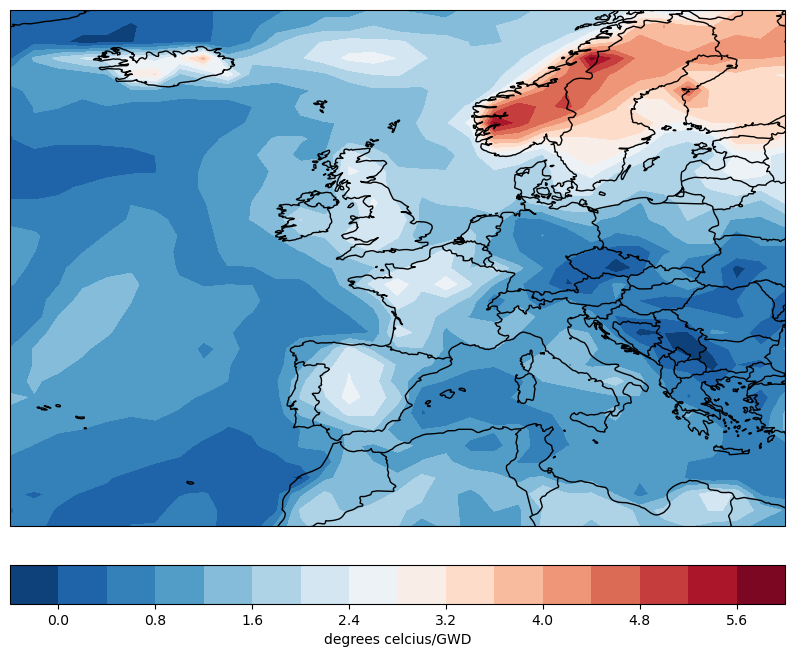

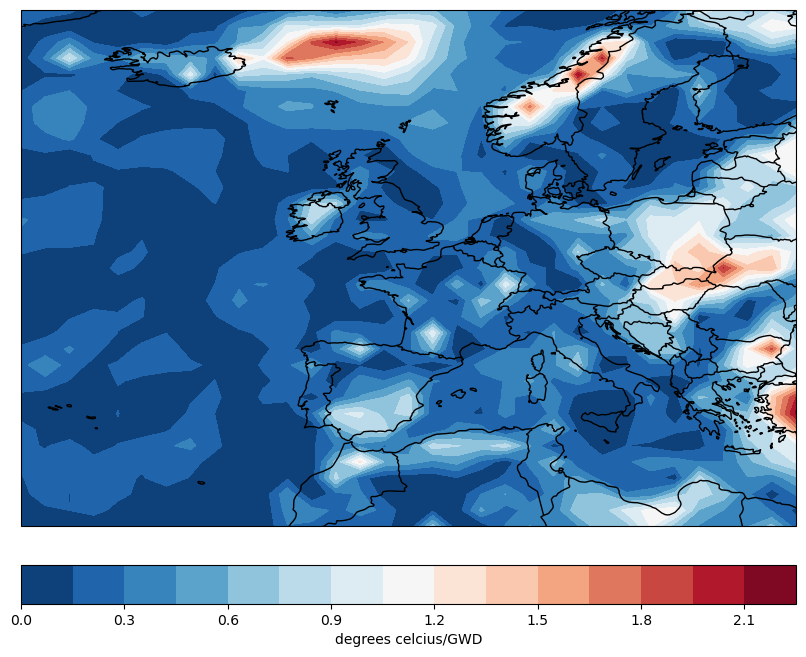

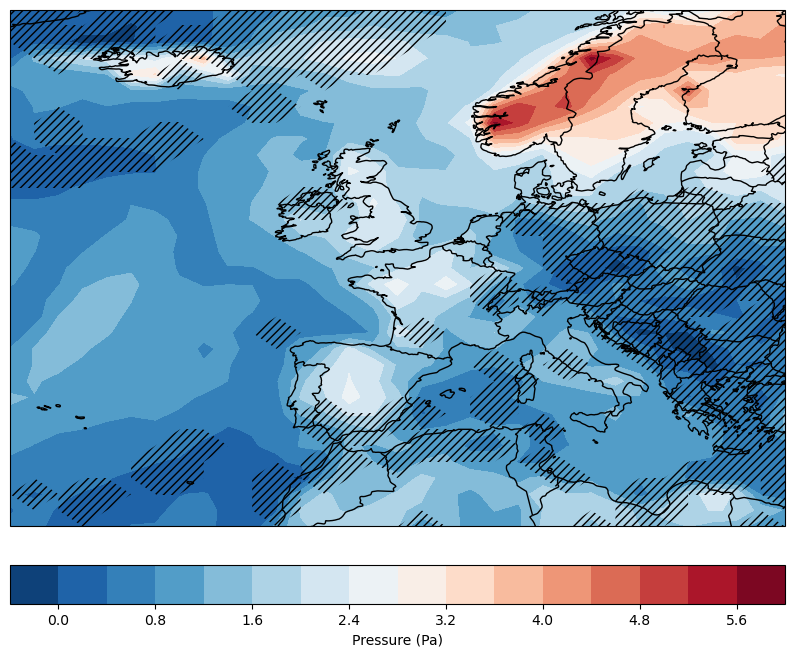

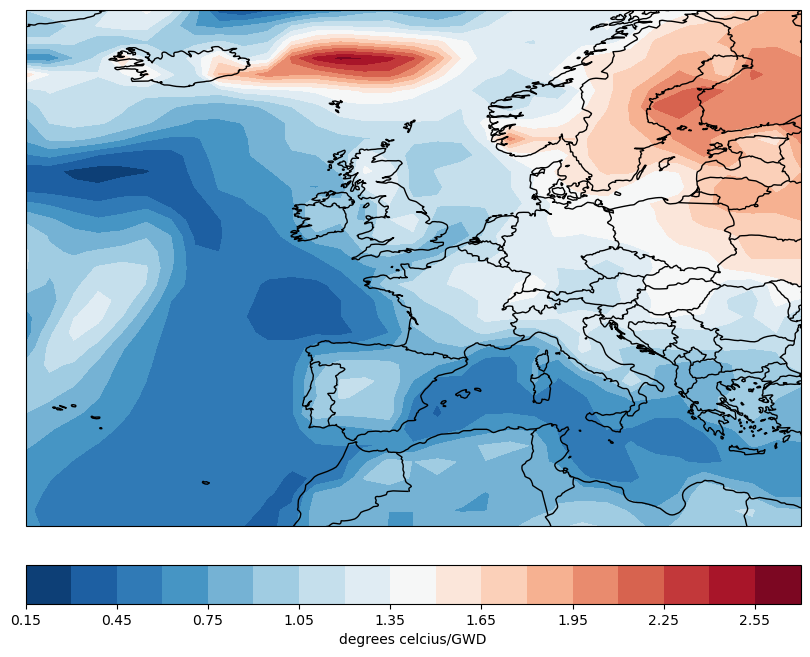

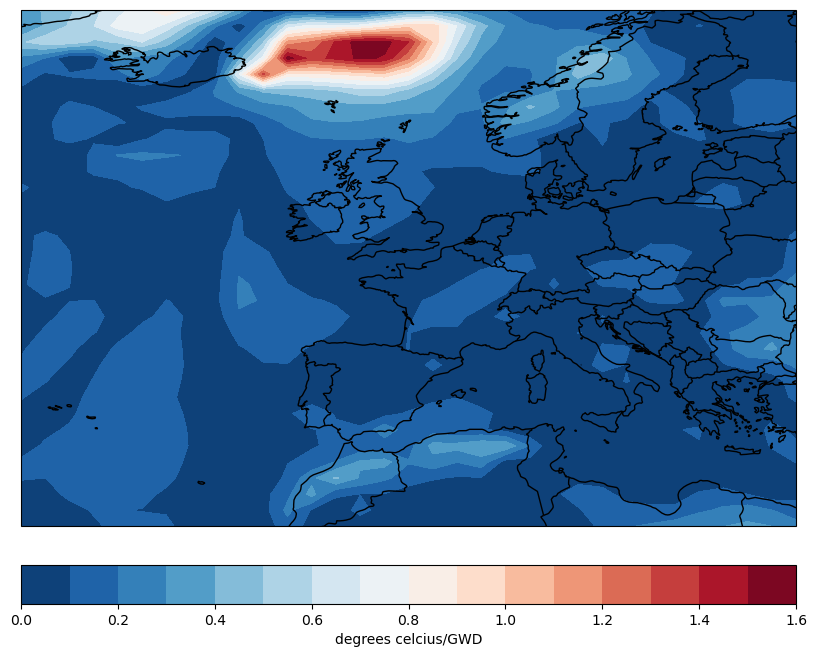

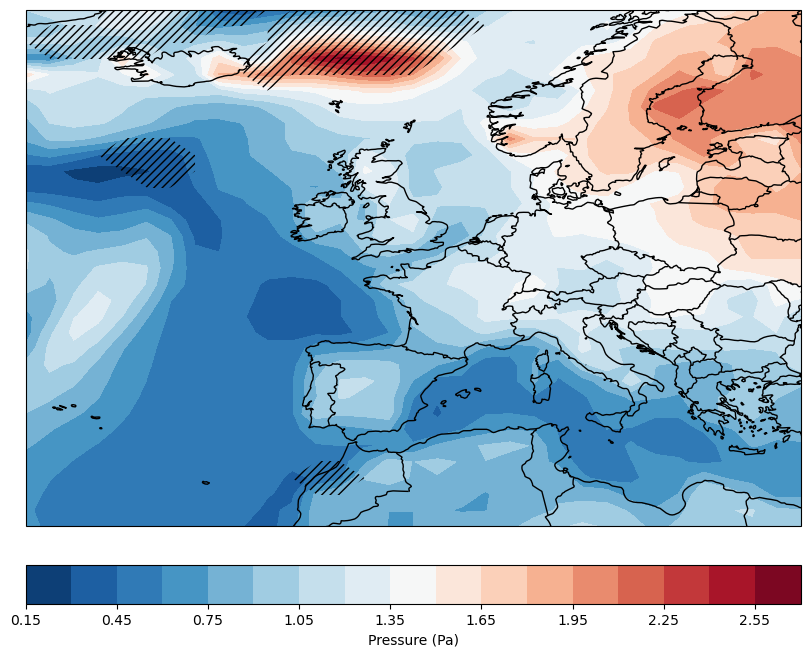

average trend Txx: 1.3392245002014034
average trend Txm: 1.1853431028759274


In [21]:
lattest,lontest,testxxm_mean,test_std_txx = temperature_trend_combined(data_path_tasV,data_path_tasmaxV,amount_of_ensembles_to_runV,S1,N1,W1,E1,start_dayV,end_dayV,save_pathV,season_nameV,land_mask_pathV,S_A,N_A,W_A,E_A,save_output = save_outputV,plot_output = plot_outputV)

# **Proberen**